# Tutorial 2 - JupyterNB
In this exercise, we model the propagation of sound waves in a one-dimensional fluid duct using finite element method (FEM). As a result, the Helmholtz equation is the governing equation which undergo discretisation with suitable finite elements to approximate the wave propoagation phenomenon in the discretised domain.

The following script guides you through the various steps in the modelling procedure. The final aim of the exercise is the following:
1. Compute the numerical solution with the *direct* approach
2. Compute the numerical solution with the *modal* approach
3. Comparison of the solutions obtained from the above two cases

## 1. Import packages
The required python packages:

In [62]:
!pip3 install numpy scipy matplotlib --user --quiet

import numpy as np
import numpy.matlib
import scipy.linalg as la
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=UserWarning)

You are using pip version 18.1, however version 23.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## 2. Pre-processing
Pre-processing includes definition of material properties, connectivity matrix (mesh), boundary conditions and geometry. In addition, the specifics of the respective analysis (here specifics for the direct and modal superposition) is defined.

In [63]:
total_L  = 0.85                                                         # Length of 1D fluid domain (duct)
noNodes  = 5                                                            # Number of nodes in domain

coord    = np.linspace(0, total_L, noNodes)                             # x-Coordinates of nodes; x is the direction of the fluid duct
param    = np.array([1, 2])                                             # no. of unknowns per node, no. of unknowns per element
r        = np.matlib.repmat(np.arange(1, noNodes-1), 2, 1)
connect  = np.append(np.append(0, r), noNodes-1).reshape(2, noNodes-1)  # matrix containing node connectivity (the mesh)
material = np.array([340, 1.2]);                                        # matrix containing homogeneous material parameters (Speed of Sound, Density); with damping: [340-17i 1.2] 

displacementLoad = np.array([1, 0, 0.01]);                              # disp-load - Node no., dof direction, Magnitude of displacement u

f        = np.arange(5, 1005, 5);                                       # Frequencies to be solved
fPlot    = np.array([200, 400, 600, 800]);                              # Frequencies at which pressure distribution is plotted (analytical eigenfrequencies)
N = noNodes;                                                            # Number of eigenfrequencies to be considered for superposition (the first of them is a rigid body mode!)
Nplot = 4                                                               # Number of eigenfrequencies to be plotted 
eigenFreqsAnalytical = np.zeros(Nplot)
for n in range(Nplot):
    eigenFreqsAnalytical[n] = (n+1)*material[0] / (2 * total_L)

## 3. FEM - Assembling and solving FE matrices
This is the main part in an FEM procedure. Here, the different elemental matrices are built, assembled and solved to obtain the primary solution.

### 3.1 Elemental stiffness matrix | BuildKEleMat_linear (Function)
The routine BuildKEleMat_linear builds the 1D fluid element stiffness matrix $K_{Ele}$ for linear ansatz functions.

Element length: $L = x_1 - x_0$

Element stiffness matrix: $K_{Ele} =
\begin{bmatrix}
\frac{1}{L} & -\frac{1}{L}\\
-\frac{1}{L} & \frac{1}{L}
\end{bmatrix}$

In [64]:
# @brief function to compute the elemental stiffness matrix
# @input coord - nodal coordinates of the element
# @output KEle - elemental stiffness matrix
def BuildKEleMat_linear(coord):
    # Generating the needed variables
    L  = coord[1]-coord[0];             # Element length
    
    # Calculating the element stiffness matrix KEle:
    KEle = [[1/L, -1/L], [-1/L, 1/L]]
    return KEle

### 3.2 Elemental mass matrix | BuildMEleMat_linear (Function)
The routine BuildMEleMat_linear builds the 1D fluid element mass matrix $M_{Ele}$ for linear ansatz functions.

Element length: $L = x_1 - x_0$

Element mass matrix: $M_{Ele} =
\begin{bmatrix}
\frac{L}{3} & \frac{L}{6}\\
\frac{L}{6} & \frac{L}{3}
\end{bmatrix}$

In [65]:
# @brief function to compute the elemental mass matrix
# @input coord - nodal coordinates of the element
# @output MEle - elemental mass matrix
def BuildMEleMat_linear(coord):
    # Generating the needed variables
    L  = coord[1]-coord[0];             # Element length
    
    # Calculating the element stiffness matrix MEle:
    MEle = [[L/3, L/6], [L/6, L/3]]
    return MEle

### 3.3 Definition of material parameters, loading and solution unknowns

In [66]:
c              = material[0]                     # Speed of sound
rho            = material[1]                     # Density

nUnknNode      = param[0]                        # number of unknowns per node
nNodes         = coord.shape[0]                  # number of nodes
nEle           = connect.shape[1]                # number of elements
nNodesEle      = connect.shape[0]                # number of nodes per element
nUnknElePres   = nUnknNode * nNodesEle           # number of unknowns per element                                        
nUnkn          = nUnknNode * nNodes              # total number of unknowns
nDispLoad      = 1                               # number of flux boundary conditions

pressure       = np.zeros((f.shape[0], nUnkn))   # Initialisation of solution vector
pressureModal  = np.zeros((f.shape[0], nUnkn))   # Initialisation of solution vector

### 3.4 Assembling of global stiffness matrix K
#### Element stiffness matrices obtained using BuildKEleMat_linear:
$K_0 = \begin{bmatrix} 4.706 & -4.706\\ -4.706 & 4.706 \end{bmatrix}
,\qquad
K_1 = \begin{bmatrix} 4.706 & -4.706\\ -4.706 & 4.706 \end{bmatrix}
,\qquad \dots$

#### Global stiffness matrix:
Step 1: $K =
\begin{bmatrix}
\boxed{\begin{matrix} 4.706 & -4.706\\ -4.706 & 4.706 \end{matrix}}_{K_0} & \dots & \begin{matrix} 0 & 0\\ 0 & 0\end{matrix}\\
\vdots\qquad\,\,\,\,\,\,\vdots & \ddots & \vdots \\
\begin{matrix} 0\qquad & 0\\ 0\qquad & 0 \end{matrix} & \dots & \begin{matrix} 0 & 0\\ 0 & 0 \end{matrix}
\end{bmatrix}$

Step 2: $K =
\begin{bmatrix}
4.706 & \begin{matrix} -4.706\,\,\,\,\,\,\, & 0\,\,\,\,\,\,\,\, \end{matrix} & \dots & \begin{matrix} 0 & 0 \end{matrix}\\
\begin{matrix} -4.706 \\ 0 \end{matrix} & \boxed{\begin{matrix} 9.41 & -4.706\\ -4.706 & 4.706 \end{matrix}} & \dots & \begin{matrix} 0 & 0\\ 0 & 0\end{matrix}\\
\vdots & \vdots\qquad\,\,\,\,\,\,\vdots & \ddots & \vdots\\
\begin{matrix} 0\\ 0 \end{matrix} & \begin{matrix} 0\qquad & 0\\ 0\qquad & 0 \end{matrix} & \dots & \begin{matrix} 0 & 0\\ 0 & 0 \end{matrix}
\end{bmatrix}$

$\dots$

In [67]:
K = np.zeros((nUnkn, nUnkn))    
for i in range(nEle):
    KEle = BuildKEleMat_linear(coord[connect[:,i]])
    K[i:i+2, i:i+2] += KEle 

print(K)

[[ 4.70588235 -4.70588235  0.          0.          0.        ]
 [-4.70588235  9.41176471 -4.70588235  0.          0.        ]
 [ 0.         -4.70588235  9.41176471 -4.70588235  0.        ]
 [ 0.          0.         -4.70588235  9.41176471 -4.70588235]
 [ 0.          0.          0.         -4.70588235  4.70588235]]


### 3.5 Assembling of global mass matrix M
#### Element mass matrices obtained using BuildMEleMat_linear:
$M_0 = \begin{bmatrix} 0.071 & 0.035\\ 0.035 & 0.071 \end{bmatrix}
,\qquad
M_1 = \begin{bmatrix} 0.071 & 0.035\\ 0.035 & 0.071 \end{bmatrix}
,\qquad \dots$

#### Global mass matrix:
Step 1: $M =
\begin{bmatrix}
\boxed{\begin{matrix} 0.071 & 0.035\\ 0.035 & 0.071 \end{matrix}}_{M_0} & \dots & \begin{matrix} 0 & 0\\ 0 & 0\end{matrix}\\
\vdots\qquad\,\,\,\,\,\,\vdots & \ddots & \vdots \\
\begin{matrix} 0\qquad & 0\\ 0\qquad & 0 \end{matrix} & \dots & \begin{matrix} 0 & 0\\ 0 & 0 \end{matrix}
\end{bmatrix}$

Step 2: $M =
\begin{bmatrix}
0.071 & \begin{matrix} 0.035\,\,\,\,\,\,\, & 0\,\,\,\,\,\,\,\, \end{matrix} & \dots & \begin{matrix} 0 & 0 \end{matrix}\\
\begin{matrix} 0.035 \\ 0 \end{matrix} & \boxed{\begin{matrix} 0.142 & 0.035\\ 0.035 & 0.071 \end{matrix}} & \dots & \begin{matrix} 0 & 0\\ 0 & 0\end{matrix}\\
\vdots & \vdots\qquad\,\,\,\,\,\,\vdots & \ddots & \vdots\\
\begin{matrix} 0\\ 0 \end{matrix} & \begin{matrix} 0\qquad & 0\\ 0\qquad & 0 \end{matrix} & \dots & \begin{matrix} 0 & 0\\ 0 & 0 \end{matrix}
\end{bmatrix}$

$\dots$

In [68]:
M = np.zeros((nUnkn,nUnkn)); 
for i in range(nEle):  
    MEle = BuildMEleMat_linear(coord[connect[:,i]])
    M[i:i+2, i:i+2] += MEle 

print(M)

[[0.07083333 0.03541667 0.         0.         0.        ]
 [0.03541667 0.14166667 0.03541667 0.         0.        ]
 [0.         0.03541667 0.14166667 0.03541667 0.        ]
 [0.         0.         0.03541667 0.14166667 0.03541667]
 [0.         0.         0.         0.03541667 0.07083333]]


### 3.6 Numerical modal analysis

In this step, the following eigenvalue problem is solved.
\begin{equation}
\left( c^2 K - \lambda M \right) \phi = 0
\end{equation}
where $\lambda$ is a diagonal matrix of all eigenvalues and $\phi$ contains eigenvectors in the respective columns.

In python, we use the "la.eig" from scipy package to solve the eigenvalue problem.

The eigenfrequencies can be obtained from the eigenvalues using:
\begin{equation}
f_i = \frac{\sqrt{\lambda_i^2}}{2\pi}
\end{equation}

In [69]:
eigenValues, eigenVectors = la.eig(np.square(c)*K, M)           # Solve eigenvalue problem

idx = eigenValues.argsort()
eigenValues = eigenValues[idx]

eigenVectors = eigenVectors[:,idx]

eigenFrequencies = np.real(np.sqrt(eigenValues)/(2 * np.pi))    # Calculate frequencies under exclusion of rigid body mode

print(eigenFrequencies)

[  0.         205.17181698 441.06311634 716.74513606 882.12623267]


### 3.7 Solving for frequency responses

Now, we can proceed to compute the frequency response of the system at various frequencies using the following two approaches. 
#### Solution using the modal superposition approach
In this approach, the modal transformation is performed to obtain the reduced matrices in the modal space. The modal transformation reads:
\begin{equation}
\begin{aligned}
\hat{R} &= \phi^T c^2 R \rightarrow \text{Modal load vector} \\
\hat{K} &= \phi^T c^2 K \phi \rightarrow \text{Modal stiffness matrix}\\
\hat{M} &= \phi^T M \phi \rightarrow \text{Modal mass matrix}
\end{aligned}
\end{equation}

Now we can perform the solving procedure for every frequency in the modal space with:
\begin{equation}
\begin{aligned}
\left(\hat{K} - \omega^2\hat{M}\right)\hat{p} &= \hat{R} \\
\Rightarrow \hat{p} &= \left(\hat{K} - \omega^2\hat{M}\right)^{-1} \hat{R}
\end{aligned}
\end{equation}
where $\hat{p}$ is the solution in modal space corresponding to the modal degrees of freedom.

The solution in the original space can be obtained by the superposition of weighted eigenvectors, which reads:
\begin{equation}
p = \sum_{i=1}^{N} \hat{p}_i \phi_i
\end{equation}

#### Solution using the direct approach

In the direct approach, we compute the solution in the conventional way by inverting the assembled system of matrices and multiplied with the load vector. The resulting equation reads:
\begin{equation}
\begin{aligned}
\left({K} - k^2{M}\right){p} &= {R} \\
\Rightarrow {p} &= \left({K} - k^2{M}\right)^{-1} {R}
\end{aligned}
\end{equation}

In [70]:
for n in range(len(f)):                          # for every frequency
    omega = 2 * np.pi * f[n]                     # Angular frequency
    kWave = omega / c;                           # wave number

    # Assembling of global excitation vector R
    R = np.zeros((nUnkn, 1))
    # Insertion of the nodal loads into the vector R:
    for i in range(nDispLoad):
        ipos    = int((displacementLoad[0] - 1) * nUnknNode + displacementLoad[1])
        R[ipos] += rho * np.square(omega) * displacementLoad[2]
    
    # Modal Solution (superposition)
    Rmod = np.matmul(np.transpose(eigenVectors[:,:N]),(np.square(c)*R))                                # Reduced load vector
    Kmod = np.matmul(np.matmul(np.transpose(eigenVectors[:,:N]),(np.square(c)*K)),eigenVectors[:,:N])  # Reduced matrix K
    Mmod = np.matmul(np.matmul(np.transpose(eigenVectors[:,:N]),M),eigenVectors[:,:N])                 # Reduced matrix M
    Gmod = Kmod - np.square(omega) * Mmod                                                              # Reduced system Matrix
    solutionVectorMod = np.matmul(la.inv(Gmod),Rmod)                                                   # Solver call of reduced system (modal)
    pressureModal[n] = np.reshape(np.matmul(eigenVectors[:,:N],solutionVectorMod), nUnkn)              # Calculate actual field values (modal transformation)
    
    # Direct Solution
    G = K - np.square(kWave) * M                                                                       # System Matrix
    solutionVector = np.matmul(la.inv(G),R)                                                            # Solver call of full system (direct)
    pressure[n] = np.reshape(solutionVector, nUnkn)                                                    # Save field values

## 4. Visualisation

In this section, we visualise the solution obtained from the steps above. A post-processing is performed on the primary solution to obtain the mean squared pressure over frequency.

### 4.1 Solution obtained using the modal superposition approach
Following we plot the first few mode shapes (expect the rigid body mode) and the mean squared pressure obtained after post-processing the primary nodal solution. The numerical and analytical eigenfrequencies can also be seen in the plot for mean squared pressure plot. It can be observed that, due to the wave resolving nature of FEM, the numerical solution converges to that of the analytical solution with finer meshes.

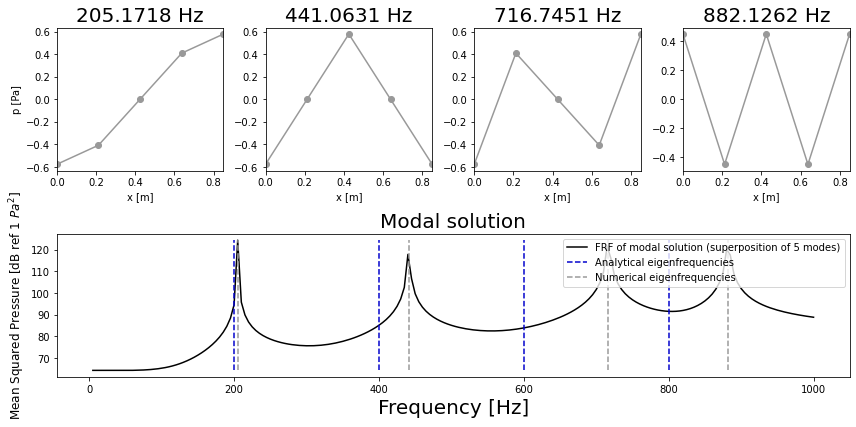

In [71]:
# FRF
plt.figure(figsize=[12.0, 6.0])
plt.subplot(2, Nplot, (5,8))
meanSquaredPressureModal = np.sum(np.square(np.abs(pressureModal)),1) / pressureModal.shape[1]
plt.plot(f, 10*np.log10(meanSquaredPressureModal), '-k')
plt.gca().set_title('Modal solution', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Mean Squared Pressure [dB ref 1 $Pa^2$]', fontsize=12)

minimumPressure = np.min(10*np.log10(meanSquaredPressureModal))
maximumPressure = np.max(10*np.log10(meanSquaredPressureModal)) 

# Mode shapes and eigenfrequencies - rigid body mode (first mode) is skipped
for n in range(Nplot):
    plt.subplot(2, Nplot, (5,8))
    
    # Mark analytical eigenfrequencies
    plt.plot([eigenFreqsAnalytical[n], eigenFreqsAnalytical[n]], [minimumPressure, maximumPressure], '--', color=(0, 0, 0.8))
    
    # Mark numerical eigenfrequency
    plt.plot([eigenFrequencies[n+1], eigenFrequencies[n+1]], [minimumPressure, maximumPressure], '--', color=(0.6, 0.6, 0.6))
    plt.legend([f'FRF of modal solution (superposition of {N} modes)', 'Analytical eigenfrequencies', 'Numerical eigenfrequencies'], loc='upper right', fontsize=10) 
    
    # Plot normalised mode shape
    plt.subplot(2, Nplot, n+1) 
    plt.plot(coord, eigenVectors[:, n+1], '-o', color=(0.6, 0.6, 0.6)); 
    plt.gca().set_title(f'{np.round(np.abs(eigenFrequencies[n+1]),4)} Hz', fontsize=20)
    
    # Settings
    plt.xlim((np.min(coord), np.max(coord))); 
    if n == 0:
        plt.ylabel('p [Pa]')
    plt.xlabel('x [m]')

plt.tight_layout()
plt.show()

### 4.2 Solution obtained using the direct approach
Following are the plots obtained through the direct solving approach. In addition, the pressure distribution at the nodes are also plotted individually for frequencies near to eigenfrequencies.

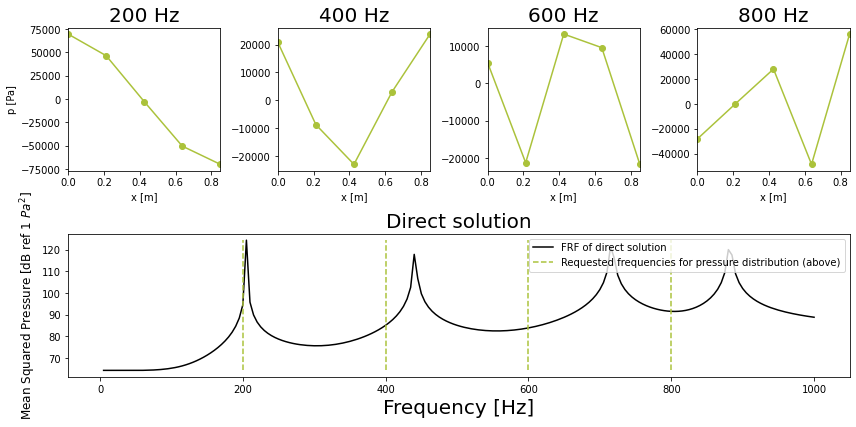

In [72]:
# FRF
plt.figure(figsize=[12.0, 6.0])
plt.subplot(2, Nplot, (5,8))
meanSquaredPressure = np.sum(np.square(np.abs(pressure)),1) / pressure.shape[1]
plt.plot(f, 10*np.log10(meanSquaredPressure), '-k')
plt.gca().set_title('Direct solution', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Mean Squared Pressure [dB ref 1 $Pa^2$]', fontsize=12)
plt.legend(('Direct', f'Modal superposition ({N} modes)'), loc='upper right', fontsize=16)

minimumPressure = np.min(10*np.log10(meanSquaredPressure))
maximumPressure = np.max(10*np.log10(meanSquaredPressure)) 

# Pressure distribution at requested frequencies
for n in range(fPlot.size):
    # Find nearest frequency solved
    freqPosition = int(np.argwhere(f>=fPlot[n])[0])

    # Mark frequency at which the pressure distribution is requested
    plt.subplot(2, fPlot.size, (5,8))
    plt.plot([fPlot[n], fPlot[n]], [minimumPressure, maximumPressure], '--', color=(0.67, 0.76, 0.23))
    plt.legend(['FRF of direct solution','Requested frequencies for pressure distribution (above)'], loc='upper right', fontsize=10) 

    # Plot spatial pressure distribution
    plt.subplot(2, Nplot, n+1) 
    plt.plot(coord, pressure[freqPosition], '-o', color=(0.67, 0.76, 0.23))
    plt.gca().set_title(f'{fPlot[n]} Hz', fontsize=20)
    
    # Settings
    plt.xlim((np.min(coord), np.max(coord)))
    if n == 0:
        plt.ylabel('p [Pa]')
    plt.xlabel('x [m]')

plt.tight_layout()
plt.show()

### 4.3 Comparison

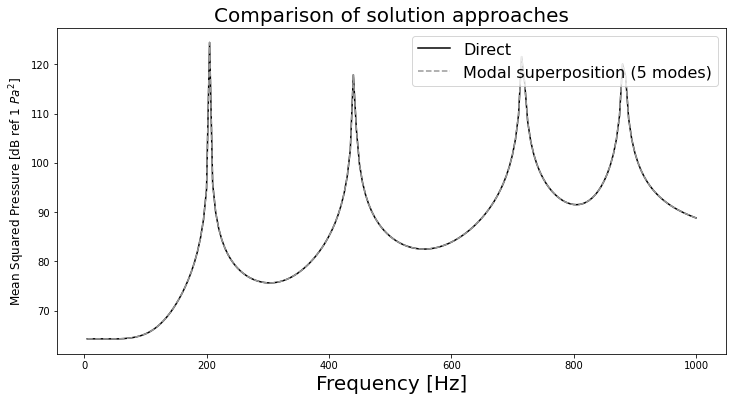

In [73]:
# FRF
plt.figure(figsize=[12.0, 6.0])
plt.plot(f, 10*np.log10(meanSquaredPressure), '-k')
plt.title('Comparison of solution approaches', fontsize=20)
plt.plot(f, 10*np.log10(meanSquaredPressureModal), '--', color=(0.6, 0.6, 0.6))
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Mean Squared Pressure [dB ref 1 $Pa^2$]', fontsize=12)
plt.legend(('Direct', f'Modal superposition ({N} modes)'), loc='upper right', fontsize=16)

plt.show()